# Defensive Stock Analysis

### Overview

Which type of analysis performs better linear regression or time series when analyzing defensive stocks? 

### Business Problem

During times of uncertainty investors want to protect their assets from loss. For this porject we will analyze 3 consumer defensive stocks by performing time series analysis (SARIMA models) and linear regression. By doing so we will try to forecast stock prices in the near future, 1 month, 2 month and 3 month spans. We will choose the 3 stocks based on highest market caps.

### Data 

### Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import time
import warnings
import scipy.stats as stats
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit 
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import preprocessing
from sklearn import utils
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# with zipfile.ZipFile("Data/archive.zip") as zip_ref:
#     zip_ref.extractall("Data")

In [3]:
df1 = pd.read_csv('Data/sp500_companies.csv')
df2 = pd.read_csv('Data/sp500_index.csv')
df3 = pd.read_csv('Data/sp500_stocks.csv')
dfg = pd.read_csv('Data/daily_gold_rate.csv')
deth = pd.read_csv('Data/CBETHUSD.csv')
dollar = pd.read_csv('Data/DTWEXBGS.csv')
ppi = pd.read_csv('Data/WPU02850113.csv')

## Datasets 

### Dataset #1

In [4]:
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,149.70,2381442449408,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.067072
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,247.11,1855296897024,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.052254
2,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.41,1249782136832,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.73,1249780563968,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,100.79,1028229365760,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.028960


In [5]:
df1 = df1[df1['Sector'] == 'Consumer Defensive']
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
11,NYQ,WMT,Walmart Inc.,Walmart Inc.,Consumer Defensive,Discount Stores,142.58,395499831296,3.458600e+10,0.084,Bentonville,AR,United States,2300000.0,Walmart Inc. engages in the operation of retai...,0.011139
13,NYQ,PG,Procter & Gamble Company (The),The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,140.97,341140373504,2.136400e+10,0.013,Cincinnati,OH,United States,106000.0,The Procter & Gamble Company provides branded ...,0.009608
20,NYQ,KO,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,61.32,264866824192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,"The Coca-Cola Company, a beverage company, man...",0.007460
22,NMS,PEP,"Pepsico, Inc.","PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,178.05,246180839424,1.515600e+10,0.088,Purchase,NY,United States,309000.0,"PepsiCo, Inc. manufactures, markets, distribut...",0.006934
23,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,515.47,228575887360,9.693000e+09,0.150,Issaquah,WA,United States,304000.0,"Costco Wholesale Corporation, together with it...",0.006438


### Dataset #2

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   S&P500  2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [7]:
df2.head()

,Date,S&P500
0,2012-11-12,1380.03
1,2012-11-13,1374.53
2,2012-11-14,1355.49
3,2012-11-15,1353.33
4,2012-11-16,1359.88


In [8]:
df2.shape

(2519, 2)

In [9]:
df2['Date'] = pd.to_datetime(df2['Date'],infer_datetime_format=True)

In [10]:
# df2=df2[df2['Date'] >= '2019-01-1']

In [11]:
df2 = df2.rename(columns={"S&P500":"SPClose"})

In [12]:
df2['Symbol'] = "S&P500"

In [13]:
df2.head()

,Date,SPClose,Symbol
0,2012-11-12,1380.03,S&P500
1,2012-11-13,1374.53,S&P500
2,2012-11-14,1355.49,S&P500
3,2012-11-15,1353.33,S&P500
4,2012-11-16,1359.88,S&P500


In [14]:
df2.isna().sum()

Date       0
SPClose    0
Symbol     0
dtype: int64

### Dataset #3

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629217 entries, 0 to 1629216
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1629217 non-null  object 
 1   Symbol     1629217 non-null  object 
 2   Adj Close  1560290 non-null  float64
 3   Close      1560290 non-null  float64
 4   High       1560290 non-null  float64
 5   Low        1560290 non-null  float64
 6   Open       1560290 non-null  float64
 7   Volume     1560290 non-null  float64
dtypes: float64(6), object(2)
memory usage: 99.4+ MB


In [16]:
df3['Date'] = pd.to_datetime(df3['Date'])

In [17]:
df3 = df3.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)

In [18]:
df3.head()

,Date,Symbol,Close
0,2010-01-04,MMM,83.019997
1,2010-01-05,MMM,82.500000
2,2010-01-06,MMM,83.669998
3,2010-01-07,MMM,83.730003
4,2010-01-08,MMM,84.320000


In [19]:
df3 = df3.loc[df3['Symbol'].isin(['PEP', 'KO', 'PG', 'WMT', 'COST'])]

In [20]:
df3.isna().sum()

Date      0
Symbol    0
Close     0
dtype: int64

In [21]:
df3['Date'] = pd.to_datetime(df3['Date'],infer_datetime_format=True)

In [22]:
# df3=df3[df3['Date'] >= '2019-01-1']

In [23]:
df3.head()

,Date,Symbol,Close
382202,2010-01-04,KO,28.520000
382203,2010-01-05,KO,28.174999
382204,2010-01-06,KO,28.165001
382205,2010-01-07,KO,28.094999
382206,2010-01-08,KO,27.575001


### Dfg 

In [24]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9824 non-null   object 
 1   USD     9824 non-null   float64
 2   EUR     9824 non-null   float64
 3   GBP     9824 non-null   float64
 4   INR     9824 non-null   float64
 5   AED     9824 non-null   float64
 6   CNY     9820 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.4+ KB


In [25]:
dfg = dfg.drop(['EUR','GBP','INR','AED','CNY'],axis=1)

In [26]:
dfg = dfg.rename(columns={"USD":"Gold"})

In [27]:
dfg.isna().sum()

Date    0
Gold    0
dtype: int64

In [28]:
dfg['Date'] = pd.to_datetime(dfg['Date'],infer_datetime_format=True)

In [29]:
# dfg=dfg[dfg['Date'] >= '2019-01-1']

In [30]:
dfg.head()

,Date,Gold
0,1985-01-01,308.30
1,1985-01-02,305.50
2,1985-01-03,302.30
3,1985-01-04,303.15
4,1985-01-07,298.25


In [31]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9824 non-null   datetime64[ns]
 1   Gold    9824 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 153.6 KB


### Deth

In [32]:
deth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1827 non-null   object
 1   CBETHUSD  1827 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


In [33]:
deth.isna().sum()

DATE        0
CBETHUSD    0
dtype: int64

In [34]:
deth = deth.rename(columns={"DATE":"Date","CBETHUSD":"Ether"})

In [35]:
deth['Date'] = pd.to_datetime(deth['Date'],infer_datetime_format=True)

In [36]:
# deth=deth[deth['Date'] >= '2019-01-1']

In [37]:
deth.head()

,Date,Ether
0,2017-11-22,381.73
1,2017-11-23,406.61
2,2017-11-24,470.98
3,2017-11-25,466.77
4,2017-11-26,473.99


### Dollar

In [38]:
dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1305 non-null   object
 1   DTWEXBGS  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [39]:
dollar.isna().sum()

DATE        0
DTWEXBGS    0
dtype: int64

In [40]:
dollar = dollar.rename(columns={"DATE":"Date", "DTWEXBGS":"USD"})

In [41]:
dollar['Date'] = pd.to_datetime(dollar['Date'],infer_datetime_format=True)

In [42]:
# dollar=dollar[dollar['Date'] >= '2019-01-1']

In [43]:
dollar.head()

,Date,USD
0,2017-11-20,111.261
1,2017-11-21,110.9836
2,2017-11-22,110.5642
3,2017-11-23,.
4,2017-11-24,110.0266


In [44]:
dollar.tail()

,Date,USD
1300,2022-11-14,123.5788
1301,2022-11-15,123.1759
1302,2022-11-16,123.4178
1303,2022-11-17,124.1229
1304,2022-11-18,123.9828


### PPI 

In [45]:
ppi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         479 non-null    object 
 1   WPU02850113  479 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [46]:
ppi.isna().sum()

DATE           0
WPU02850113    0
dtype: int64

In [47]:
ppi = ppi.rename(columns={"DATE":"Date", "WPU02850113":"PPI"})

In [48]:
ppi['Date'] = pd.to_datetime(ppi['Date'],infer_datetime_format=True)

In [ ]:
ppi

In [49]:
# ppi=ppi[ppi['Date'] >= '2019-01-1']

In [50]:
ppi.head()

,Date,PPI
0,1982-12-01,100.0
1,1983-01-01,99.7
2,1983-02-01,100.4
3,1983-03-01,101.5
4,1983-04-01,102.2


## Merge datasets

In [51]:
df4 = pd.merge(df2,df3, on='Date', how='outer')

In [52]:
df4 = pd.merge(df4, dfg, on='Date')

In [53]:
df4 = pd.merge(df4, deth, on='Date')

In [54]:
df4 = pd.merge(df4, dollar, on='Date')

In [55]:
df4 = pd.merge(df4, ppi, on='Date')

In [56]:
df4.drop('Symbol_x', axis=1)

,Date,SPClose,Symbol_y,Close,Gold,Ether,USD,PPI
0,2017-12-01,2642.22,KO,45.970001,1275.5,463.82,110.1432,186.000
1,2017-12-01,2642.22,COST,185.130005,1275.5,463.82,110.1432,186.000
2,2017-12-01,2642.22,PEP,116.779999,1275.5,463.82,110.1432,186.000
3,2017-12-01,2642.22,PG,90.360001,1275.5,463.82,110.1432,186.000
4,2017-12-01,2642.22,WMT,97.349998,1275.5,463.82,110.1432,186.000
...,...,...,...,...,...,...,...,...
185,2022-08-01,4118.63,KO,64.519997,1772.4,1629.76,121.5001,269.651
186,2022-08-01,4118.63,COST,546.809998,1772.4,1629.76,121.5001,269.651
187,2022-08-01,4118.63,PEP,176.949997,1772.4,1629.76,121.5001,269.651
188,2022-08-01,4118.63,PG,142.899994,1772.4,1629.76,121.5001,269.651


In [57]:
df4 = df4.rename(columns={'Symbol_y': 'Symbol'})

In [58]:
df4 = df4[['Date', 'Symbol', 'Close', 'SPClose','Gold','Ether','USD','PPI']]

In [94]:
df4.head(20)

,Date,Symbol,Close,SPClose,Gold,Ether,USD,PPI
0,2017-12-01,KO,45.970001,2642.22,1275.50,463.82,110.1432,186.0
1,2017-12-01,COST,185.130005,2642.22,1275.50,463.82,110.1432,186.0
2,2017-12-01,PEP,116.779999,2642.22,1275.50,463.82,110.1432,186.0
3,2017-12-01,PG,90.360001,2642.22,1275.50,463.82,110.1432,186.0
4,2017-12-01,WMT,97.349998,2642.22,1275.50,463.82,110.1432,186.0
5,2018-02-01,KO,47.450001,2821.98,1341.35,1017.48,106.4903,186.2
6,2018-02-01,COST,193.470001,2821.98,1341.35,1017.48,106.4903,186.2
7,2018-02-01,PEP,120.300003,2821.98,1341.35,1017.48,106.4903,186.2
8,2018-02-01,PG,85.849998,2821.98,1341.35,1017.48,106.4903,186.2
9,2018-02-01,WMT,105.519997,2821.98,1341.35,1017.48,106.4903,186.2


In [60]:
df4['USD']=df4['USD'].astype(float)

In [61]:
df4['Ether']=df4['Ether'].astype(float)

In [62]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     190 non-null    datetime64[ns]
 1   Symbol   190 non-null    object        
 2   Close    190 non-null    float64       
 3   SPClose  190 non-null    float64       
 4   Gold     190 non-null    float64       
 5   Ether    190 non-null    float64       
 6   USD      190 non-null    float64       
 7   PPI      190 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.4+ KB


## EDA

In [63]:
symbol_groups = df4.groupby(by='Symbol')

In [64]:
COST = symbol_groups.get_group('COST')
WMT = symbol_groups.get_group('WMT')
KO = symbol_groups.get_group('KO')
PG = symbol_groups.get_group('PG')
PEP = symbol_groups.get_group('PEP')

### WMT EDA

In [65]:
wmt_corr = WMT.corr()
wmt_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.837826,0.932504,0.640993,0.218195,0.469566
SPClose,0.837826,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.932504,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.640993,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.218195,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.469566,0.657400,0.568375,0.498839,0.334263,1.000000


In [93]:
WMT

,Symbol,Close,SPClose,Gold,Ether,USD,PPI
Date,,,,,,,
2017-12-01,WMT,97.349998,2642.22,1275.50,463.82,110.1432,186.000
2018-02-01,WMT,105.519997,2821.98,1341.35,1017.48,106.4903,186.200
2018-03-01,WMT,89.080002,2677.67,1307.75,868.74,108.5384,186.300
2018-05-01,WMT,87.410004,2654.80,1307.10,670.75,109.7461,186.500
2018-06-01,WMT,82.989998,2734.62,1294.60,578.89,111.8279,186.500
2018-08-01,WMT,88.239998,2813.36,1219.00,419.60,112.8919,187.600
2018-10-01,WMT,94.400002,2924.59,1189.35,230.40,113.8247,188.300
2018-11-01,WMT,100.580002,2740.37,1231.15,197.96,115.8667,187.500
2019-02-01,WMT,93.860001,2706.53,1318.70,105.88,113.7529,185.200


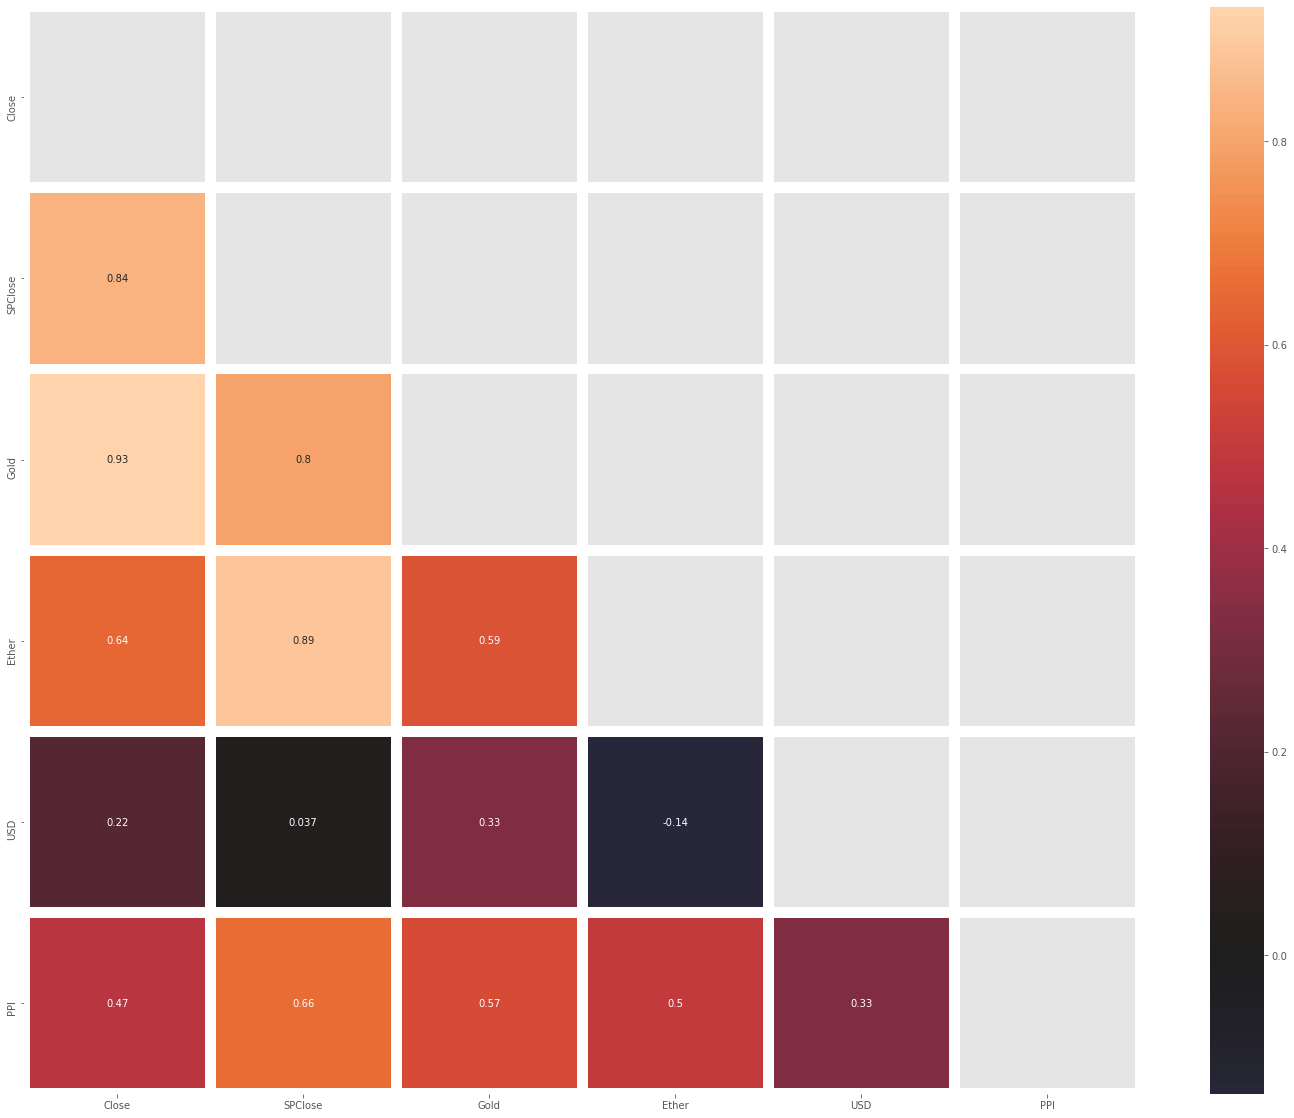

In [66]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(WMT.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(wmt_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

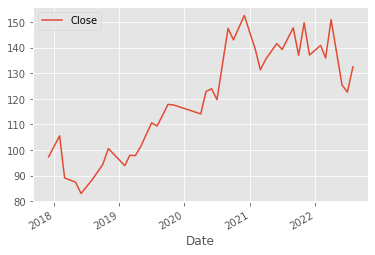

In [67]:
WMT.plot(x='Date',y='Close')

### KO EDA 

In [68]:
ko_corr = KO.corr()
ko_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.771784,0.601263,0.585042,0.256273,0.857674
SPClose,0.771784,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.601263,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.585042,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.256273,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.857674,0.657400,0.568375,0.498839,0.334263,1.000000


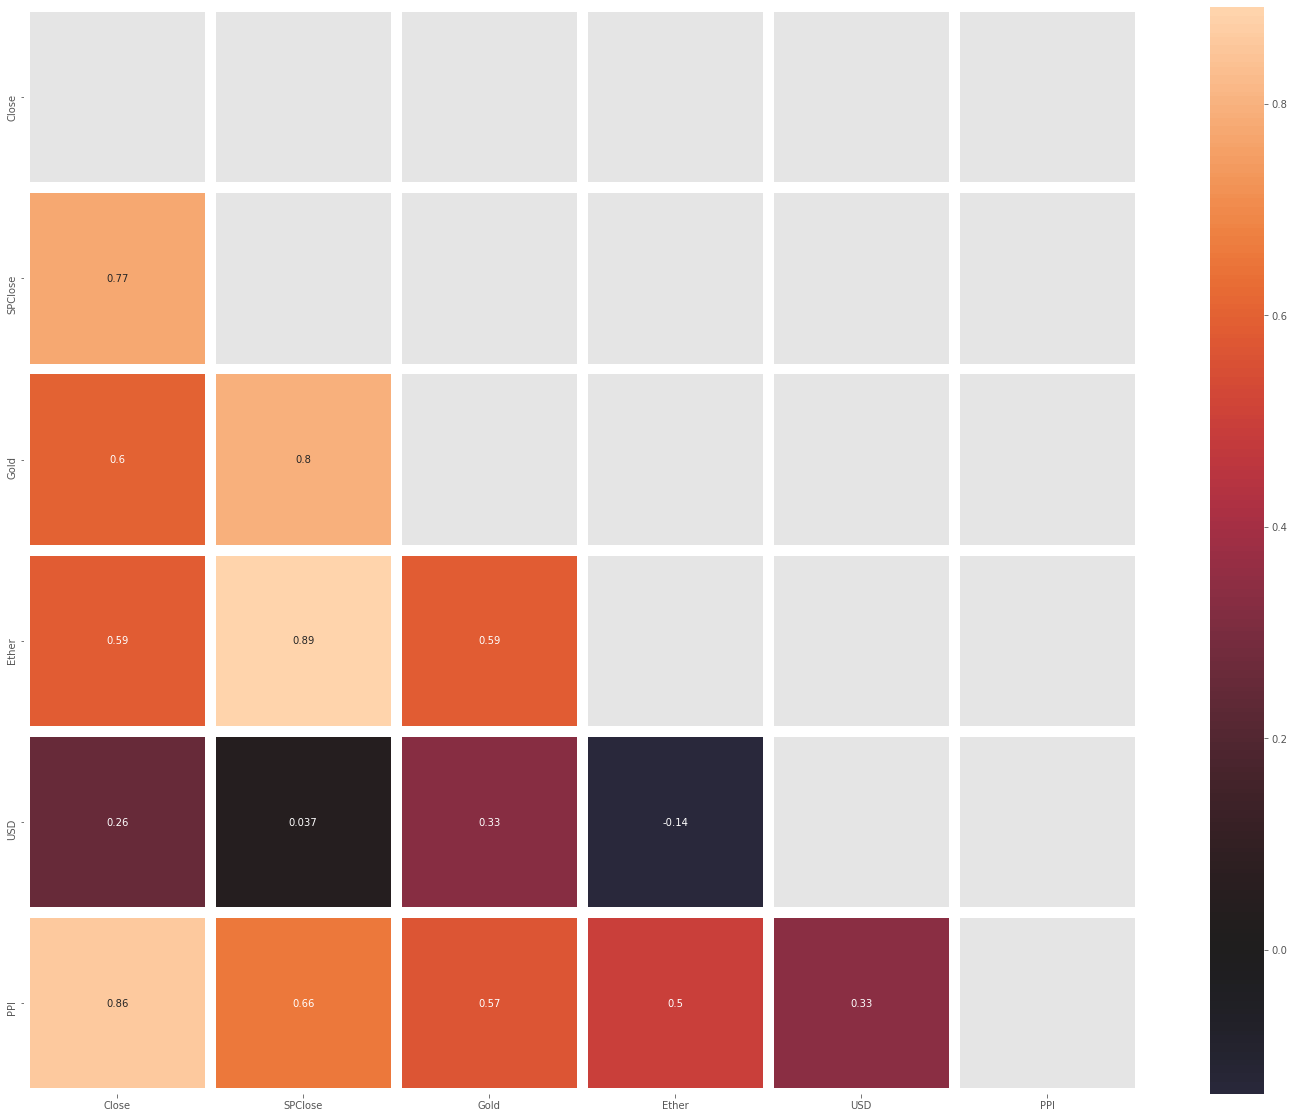

In [69]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(KO.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(ko_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

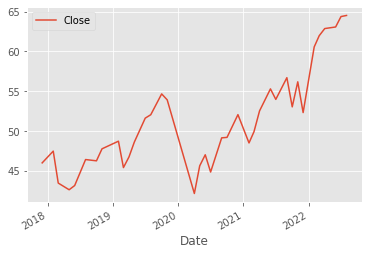

In [70]:
KO.plot(x='Date',y='Close')

### PG EDA 

In [71]:
pg_corr = PG.corr()
pg_corr

,Close,SPClose,Gold,Ether,USD,PPI
Close,1.000000,0.859708,0.900333,0.635895,0.394046,0.679719
SPClose,0.859708,1.000000,0.798416,0.891822,0.036834,0.657400
Gold,0.900333,0.798416,1.000000,0.588299,0.327380,0.568375
Ether,0.635895,0.891822,0.588299,1.000000,-0.136091,0.498839
USD,0.394046,0.036834,0.327380,-0.136091,1.000000,0.334263
PPI,0.679719,0.657400,0.568375,0.498839,0.334263,1.000000


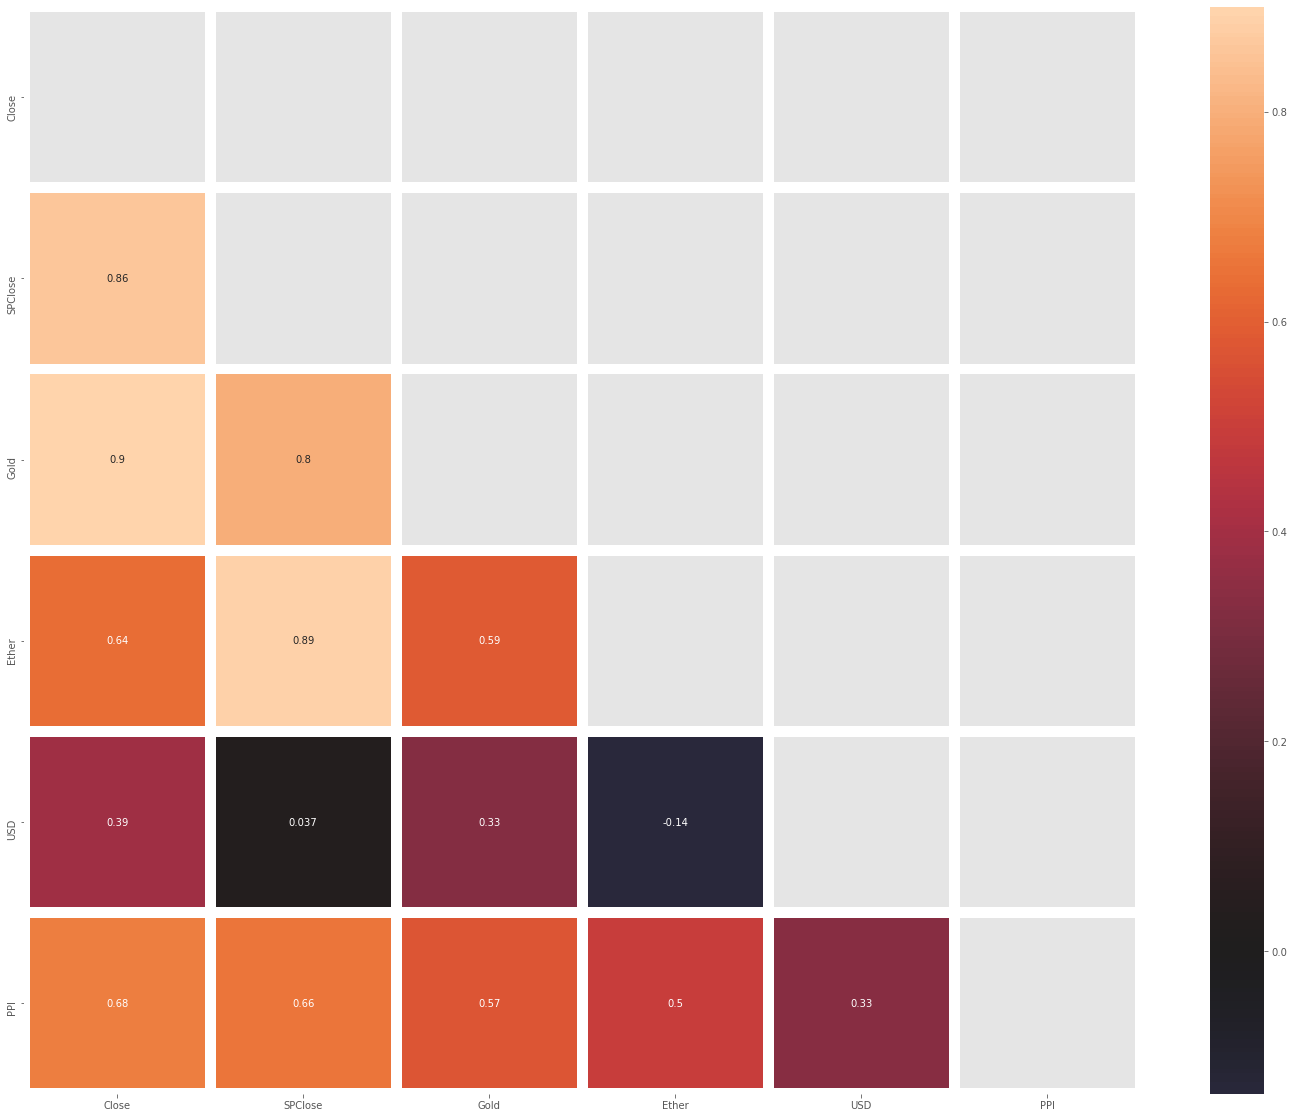

In [72]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(PG.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(pg_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

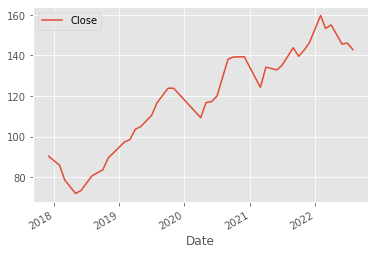

In [73]:
PG.plot(x='Date',y='Close')

### Preprocessing

In [75]:
WMT_new = WMT.drop(['SPClose','Gold','PPI','Ether','USD','Symbol'],axis=1)

In [76]:
WMT_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 4 to 189
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    38 non-null     datetime64[ns]
 1   Close   38 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 912.0 bytes


In [77]:
# Make sure that index is DatetimeIndex named "date"
if isinstance(WMT.index, pd.DatetimeIndex):
    WMT.index.name = 'Date'
else:
    WMT.rename(columns={'index':'Date'}, inplace=True)
    WMT.set_index('Date', inplace=True)
    
WMT

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Symbol,Close,SPClose,Gold,Ether,USD,PPI
Date,,,,,,,
2017-12-01,WMT,97.349998,2642.22,1275.50,463.82,110.1432,186.000
2018-02-01,WMT,105.519997,2821.98,1341.35,1017.48,106.4903,186.200
2018-03-01,WMT,89.080002,2677.67,1307.75,868.74,108.5384,186.300
2018-05-01,WMT,87.410004,2654.80,1307.10,670.75,109.7461,186.500
2018-06-01,WMT,82.989998,2734.62,1294.60,578.89,111.8279,186.500
2018-08-01,WMT,88.239998,2813.36,1219.00,419.60,112.8919,187.600
2018-10-01,WMT,94.400002,2924.59,1189.35,230.40,113.8247,188.300
2018-11-01,WMT,100.580002,2740.37,1231.15,197.96,115.8667,187.500
2019-02-01,WMT,93.860001,2706.53,1318.70,105.88,113.7529,185.200


In [78]:
wmt_new = WMT.asfreq('D')

# The 'MS' string groups the data in buckets by start of the month
wmt_new = wmt_new['Close'].resample('MS').mean()

wmt_new

Date
2017-12-01     97.349998
2018-01-01           NaN
2018-02-01    105.519997
2018-03-01     89.080002
2018-04-01           NaN
2018-05-01     87.410004
2018-06-01     82.989998
2018-07-01           NaN
2018-08-01     88.239998
2018-09-01           NaN
2018-10-01     94.400002
2018-11-01    100.580002
2018-12-01           NaN
2019-01-01           NaN
2019-02-01     93.860001
2019-03-01     97.930000
2019-04-01     97.820000
2019-05-01    101.360001
2019-06-01           NaN
2019-07-01    110.620003
2019-08-01    109.379997
2019-09-01           NaN
2019-10-01    117.849998
2019-11-01    117.620003
2019-12-01           NaN
2020-01-01           NaN
2020-02-01           NaN
2020-03-01           NaN
2020-04-01    114.139999
2020-05-01    122.919998
2020-06-01    123.959999
2020-07-01    119.690002
2020-08-01           NaN
2020-09-01    147.589996
2020-10-01    143.080002
2020-11-01           NaN
2020-12-01    152.639999
2021-01-01           NaN
2021-02-01    139.270004
2021-03-01    131.36

In [79]:
# The term bfill means that we use the value before filling in missing values
wmt_new = wmt_new.fillna(wmt_new.bfill())

wmt_new

Date
2017-12-01     97.349998
2018-01-01    105.519997
2018-02-01    105.519997
2018-03-01     89.080002
2018-04-01     87.410004
2018-05-01     87.410004
2018-06-01     82.989998
2018-07-01     88.239998
2018-08-01     88.239998
2018-09-01     94.400002
2018-10-01     94.400002
2018-11-01    100.580002
2018-12-01     93.860001
2019-01-01     93.860001
2019-02-01     93.860001
2019-03-01     97.930000
2019-04-01     97.820000
2019-05-01    101.360001
2019-06-01    110.620003
2019-07-01    110.620003
2019-08-01    109.379997
2019-09-01    117.849998
2019-10-01    117.849998
2019-11-01    117.620003
2019-12-01    114.139999
2020-01-01    114.139999
2020-02-01    114.139999
2020-03-01    114.139999
2020-04-01    114.139999
2020-05-01    122.919998
2020-06-01    123.959999
2020-07-01    119.690002
2020-08-01    147.589996
2020-09-01    147.589996
2020-10-01    143.080002
2020-11-01    152.639999
2020-12-01    152.639999
2021-01-01    139.270004
2021-02-01    139.270004
2021-03-01    131.36

In [80]:
monthly_mean_wmt = wmt_new.resample('M').mean()

In [81]:
monthly_mean_wmt

Date
2017-12-31     97.349998
2018-01-31    105.519997
2018-02-28    105.519997
2018-03-31     89.080002
2018-04-30     87.410004
2018-05-31     87.410004
2018-06-30     82.989998
2018-07-31     88.239998
2018-08-31     88.239998
2018-09-30     94.400002
2018-10-31     94.400002
2018-11-30    100.580002
2018-12-31     93.860001
2019-01-31     93.860001
2019-02-28     93.860001
2019-03-31     97.930000
2019-04-30     97.820000
2019-05-31    101.360001
2019-06-30    110.620003
2019-07-31    110.620003
2019-08-31    109.379997
2019-09-30    117.849998
2019-10-31    117.849998
2019-11-30    117.620003
2019-12-31    114.139999
2020-01-31    114.139999
2020-02-29    114.139999
2020-03-31    114.139999
2020-04-30    114.139999
2020-05-31    122.919998
2020-06-30    123.959999
2020-07-31    119.690002
2020-08-31    147.589996
2020-09-30    147.589996
2020-10-31    143.080002
2020-11-30    152.639999
2020-12-31    152.639999
2021-01-31    139.270004
2021-02-28    139.270004
2021-03-31    131.36

### SARIMA model WMT

In [82]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [83]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean_wmt,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=698.9479458092487
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=521.4251418051593
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=387.8855338695862
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=1213.7701156717362
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=383.5370700430021
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=369.7336117970756
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=289.1988413337509
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=1232.8188899120933
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=618.7739277994842
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=458.26199178001275
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=349.56008328562035
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1127.3442305655583
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=358.4436448741885
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=340.3320008847448
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=272.3980917496168
ARIMA

In [84]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(monthly_mean_wmt, 
                                        order=(5, 5, 5), 
                                        seasonal_order=(1, 1, 1, 12), 
#                                         enforce_stationarity=False, 
                                         enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4639    5.5e-21  -4.48e+20      0.000      -2.464      -2.464
ar.L2         -2.9781   1.32e-22  -2.26e+22      0.000      -2.978      -2.978
ar.L3         -2.2054   8.99e-21  -2.45e+20      0.000      -2.205      -2.205
ar.L4         -1.0362      8e-21  -1.29e+20      0.000      -1.036      -1.036
ar.L5         -0.1702   5.65e-21  -3.01e+19      0.000      -0.170      -0.170
ma.L1          0.7117   1.95e-19   3.65e+18      0.000       0.712       0.712
ma.L2          1.5363   3.23e-19   4.76e+18      0.000       1.536       1.536
ma.L3          0.7133   3.96e-19    1.8e+18      0.000       0.713       0.713
ma.L4          0.7721   3.34e-20   2.31e+19      0.000       0.772       0.772
ma.L5          0.4194   3.94e-19   1.06e+18      0.000       0.419       0.419
ar.S.L12       0.4593   6.09e-21   7.54e+19      0.0

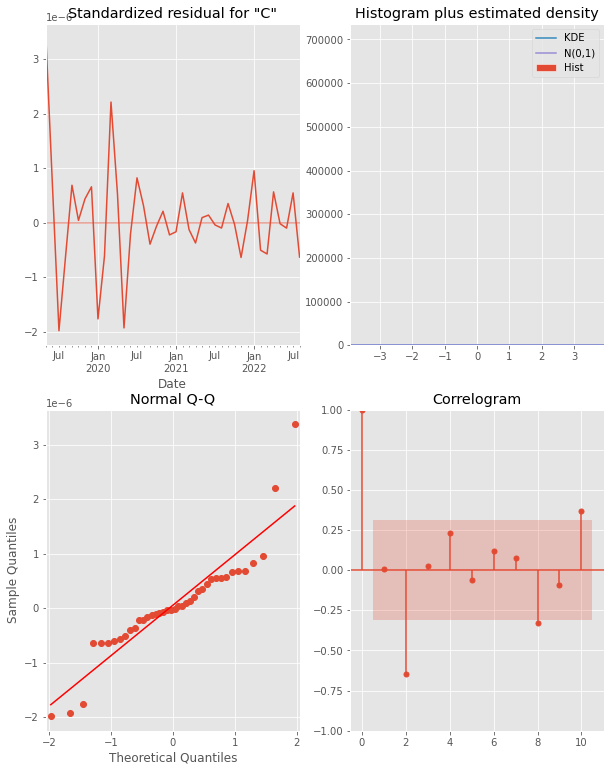

In [85]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(10, 13))
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

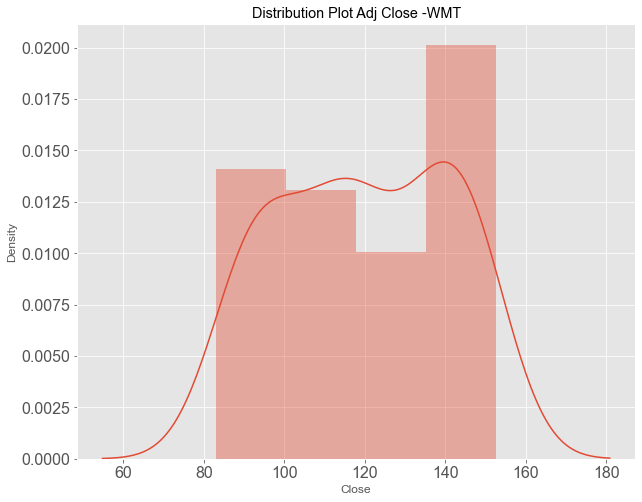

In [86]:
##Checking Distribution of Our Data 
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_mean_wmt).set_title("Distribution Plot Adj Close -WMT")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [87]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False)
pred_conf = pred.conf_int()

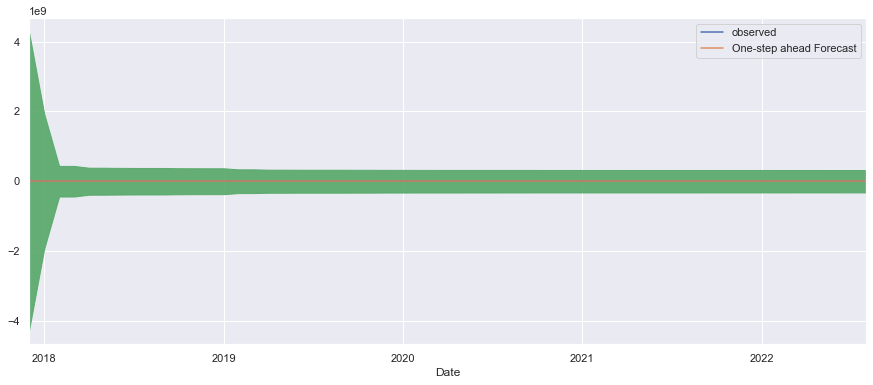

In [88]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = monthly_mean_wmt['2017':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.9)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('')
plt.legend()

plt.show()

In [91]:
pred.predicted_mean

Date
2017-12-31      0.000000
2018-01-31    400.146240
2018-02-28    128.781359
2018-03-31   -151.602537
2018-04-30     33.386665
2018-05-31    402.043244
2018-06-30    101.789464
2018-07-31    -72.693706
2018-08-31     19.897339
2018-09-30    141.950984
2018-10-31    139.808400
2018-11-30    141.847492
2018-12-31    232.656006
2019-01-31   -140.822147
2019-02-28    -23.027123
2019-03-31    577.243546
2019-04-30    262.437389
2019-05-31   -468.340340
2019-06-30     -3.956823
2019-07-31    442.699571
2019-08-31    215.942472
2019-09-30      2.144804
2019-10-31    110.361964
2019-11-30     44.375785
2019-12-31      4.564993
2020-01-31    406.292149
2020-02-29    214.675675
2020-03-31   -251.908634
2020-04-30     26.836490
2020-05-31    441.157400
2020-06-30    158.077017
2020-07-31    -16.495824
2020-08-31     95.658711
2020-09-30    212.042597
2020-10-31    153.246580
2020-11-30    117.651690
2020-12-31    189.018160
2021-01-31    166.240656
2021-02-28     49.003990
2021-03-31    151.63

In [89]:
# Get the real and predicted values
WMT_forecasted = pred.predicted_mean
WMT_truth = monthly_mean_wmt['2017-12-31':]

# Compute the mean square error
mse = ((WMT_forecasted - WMT_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27935.9


In [ ]:
# rcParams['figure.figsize'] = 18, 8

# decomposition = sm.tsa.seasonal_decompose(monthly_mean_wmt, model='additive')
# fig = decomposition.plot()
# plt.show()

In [ ]:
# #Plot the ACF
# fig, ax = plt.subplots(figsize=(8,3))
# plot_acf(monthly_mean_wmt,ax=ax, lags=8);

In [ ]:
# # Fit an ARMA(1,0) model
# mod_arma = ARIMA(monthly_mean_wmt, order=(1,0,0))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())

In [ ]:
# # Fit an ARMA(2,1) model
# mod_arma = ARIMA(monthly_mean_wmt, order=(2,0,1))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())

In [ ]:
# # Fit an ARMA(2,2) model
# mod_arma = ARIMA(monthly_mean_wmt, order=(2,0,2))
# res_arma = mod_arma.fit()

# # Print out summary information on the fit
# print(res_arma.summary())

### Linear Regression WMT 

In [ ]:
WMT.describe()

In [ ]:
WMT_lr = WMT

In [ ]:
# Model displays a very high R-squared which is promising
b_wmt = 'Close~Gold+Ether+USD+PPI+SPClose'

model_wmt = ols(formula=b_wmt, data=WMT_lr).fit()
model_wmt.summary()

In [ ]:
# Visualize terms, specifically Gold

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_wmt, "Gold", fig=fig)
plt.show()

# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 

In [ ]:
# Gold
WMT_lr['Gold'].hist()

In [ ]:
# in order to scale this distribution we will need to perform a log transform 
WMT_lr['log_Gold'] = np.log(WMT_lr['Gold'])
WMT_lr['log_Gold'].hist()

In [ ]:
WMT['Close'].hist()

In [ ]:
WMT_lr['log_Close'] = np.log(WMT_lr['Close'])
WMT_lr['log_Close'].hist()

In [ ]:
# final model

b2_wmt = 'log_Close~log_Gold+Ether+USD+PPI+SPClose'

model2_wmt = ols(formula=b2_wmt, data=WMT_lr).fit()
model2_wmt.summary()

In [ ]:
residuals_wmt = model2_wmt.resid
fig = sm.graphics.qqplot(residuals_wmt, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

In [ ]:
# This histogram shows the normal distribution
residuals_wmt.hist()

In [ ]:
# Perform White's test 

white_test_wmt = het_white(model2_wmt.resid, model2_wmt.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test_wmt)))

# p-value is small which shows that the residuals are homoscedastic and therefore evenly distributed

In [ ]:
residuals_wmt = model2_wmt.resid

In [ ]:
X = WMT_lr.drop(['Close', 'log_Close'], axis=1)

y_pred = model_wmt.predict(X)

In [ ]:
sns.scatterplot(y_pred,residuals_wmt)

### Linear Regression KO 

In [ ]:
KO.describe()

In [ ]:
ko_lr = KO

In [ ]:
# Model displays a very high R-squared 
b_ko = 'Close~Gold+Ether+USD+PPI+SPClose'

model_ko = ols(formula=b_ko, data=ko_lr).fit()
model_ko.summary()

In [ ]:
# Visualize terms, specifically Gold

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_ko, "PPI", fig=fig)
plt.show()

In [ ]:
ko_lr['Close'].hist()

In [ ]:
ko_lr['PPI'].hist()

In [ ]:
ko_lr['log_Close'] = np.log(ko_lr['Close'])
ko_lr['log_Close'].hist()

In [ ]:
ko_lr['log_PPI'] = np.log(ko_lr['PPI'])
ko_lr['log_PPI'].hist()

In [ ]:
# final model

b2_ko = 'log_Close~Gold+Ether+USD+log_PPI+SPClose'

model2_ko = ols(formula=b2_ko, data=ko_lr).fit()
model2_ko.summary()

In [ ]:
residuals_ko = model2_ko.resid
fig = sm.graphics.qqplot(residuals_ko, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

In [ ]:
# This histogram shows the normal distribution

residuals_ko.hist()

In [ ]:
# Perform White's test 

white_test_ko = het_white(model2_ko.resid, model2_ko.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test_ko)))

In [ ]:
residuals_ko = model2_ko.resid

In [ ]:
X_ko = ko_lr.drop(['Close', 'log_Close'], axis=1)

y_pred_ko = model_ko.predict(X_ko)

In [ ]:
sns.scatterplot(y_pred_ko,residuals_ko)

### Linear Regression PG

In [ ]:
PG.describe()

In [ ]:
pg_lr = PG

In [ ]:
# Model displays a very high R-squared 
b_pg = 'Close~Gold+Ether+USD+PPI+SPClose'

model_pg = ols(formula=b_pg, data=pg_lr).fit()
model_pg.summary()

In [ ]:
# Visualize terms, specifically Gold

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_pg, "Gold", fig=fig)
plt.show()

In [ ]:
# Gold
pg_lr['Gold'].hist()

In [ ]:
pg_lr['Close'].hist()

In [ ]:
# in order to scale this distribution we will need to perform a log transform 

pg_lr['log_Gold'] = np.log(pg_lr['Gold'])
pg_lr['log_Gold'].hist()

In [ ]:
# final model

b2_pg = 'Close~log_Gold+Ether+USD+PPI+SPClose'

model2_pg = ols(formula=b2_pg, data=pg_lr).fit()
model2_pg.summary()

In [ ]:
residuals_pg = model2_pg.resid
fig = sm.graphics.qqplot(residuals_pg, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

In [ ]:
residuals_pg.hist()

In [ ]:
X_pg = pg_lr.drop(['Close'], axis=1)

y_pred_pg = model_pg.predict(X_pg)

In [ ]:
sns.scatterplot(y_pred_pg,residuals_pg)